Additional Resources Used for this notebook:

Models and Tutorials:
[KerasYolov8_v1](https://keras.io/guides/keras_cv/object_detection_keras_cv/)
[KerasYolov8_v2](https://keras.io/examples/vision/yolov8/)
[RoboflowYolov8 ](https://roboflow.com/model/yolov8)[RoboflowYolov8 Archi](https://blog.roboflow.com/whats-new-in-yolov8/)
[model_archi](https://github.com/ultralytics/ultralytics/issues/189)

Data Processing:
[Explaning Annotation Format](https://towardsdatascience.com/image-data-labelling-and-annotation-everything-you-need-to-know-86ede6c684b1#:~:text=YOLO%3A%20In%20YOLO%20labeling%20format,object%20coordinates%2C%20height%20and%20width)
[Explaning BoundingBox Format](https://medium.com/@rajdeepsingh/a-quick-reference-for-bounding-boxes-in-object-detection-f02119ddb76b)
[BoundingBox Format1](https://keras.io/api/keras_cv/bounding_box/formats/)
[BoundingBox Format2](https://albumentations.ai/docs/)

Data:
[Main DataSource](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow)



## Setup

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q
!pip install keras_nlp

In [ ]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend


## Hyperparameters

In [ ]:
# SPLIT_RATIO = 0.2 # Don't need this since Kaggle has Train/Valid/Test

# Tunable Parameters
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

## Load Data
This dataset comes from Kaggle. First, let's bring in the data. **Important:** You need a Kaggle account and a Kaggle API Key to access this data in Colab. 1. Make an account. 2. Generate a Kaggle API key. 3. Upload the key (the file called kaggle.json to colab in the default location (under content/). 4. Run the following cell to download the relevant data.

In [ ]:
# Link to Kaggle and Load Data
!mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/kaggle.json

# Copy the API command from Kaggle, should be the following format
# !kaggle datasets download -d crowdflower/twitter-airline-sentiment -p ./airline_tweets

!kaggle datasets download -d snehilsanyal/construction-site-safety-image-dataset-roboflow -p ./construction_site
!unzip /content/construction_site/construction-site-safety-image-dataset-roboflow.zip

Creat a dictionary object to map each class name to a unique numerical identifier. This mapping is used to encode and decode the class labels during training and inference in object detection tasks.

In [ ]:
num_classes = 10
classes = [
    'Hardhat',
    'Mask',
    'NO-Hardhat',
    'NO-Mask',
    'NO-Safety Vest',
    'Person',
    'Safety Cone',
    'Safety Vest',
    'machinery',
    'vehicle']

class_mapping = dict(zip(range(num_classes), classes))

In [ ]:
# Training Data Files Path
path_images = "/content/css-data/train/images"
path_annot = "/content/css-data/train/labels"

# # Validation Data Files Path
# path_images_val = "/content/css-data/valid/images"
# path_annot_val = "/content/css-data/valid/labels"

# Testing Data Files Path
path_images_test = "/content/css-data/test/images"
path_annot_test = "/content/css-data/test/labels"

In [ ]:
# move all images in valide/images to train/images
!mv /content/css-data/valid/images/* /content/css-data/train/images

# move all labels in valide/labels to train/labels
!mv /content/css-data/valid/labels/* /content/css-data/train/labels

We can look at how many image data we have under train, validate, and test set, and what are the sizes of those images. If they are consistent, then we don't have to resize them, otherwise, we need to resize the images to keep consistency

In [ ]:
Input_path = '/content/css-data/'

for mode in ['train', 'valid', 'test']:
  files =  glob.glob(os.path.join(Input_path, mode, 'images', '*'))
  print(f'{mode} set size: {len(files)}')

  print(f'Image sizes in {mode} set: ')
  img_size = 0
  for file in files:
    # print the dataset size
    image = Image.open(file)
    if image.size != img_size:
      print(f'\t{image.size}')
      img_size = image.size

train set size: 2719
Image sizes in train set: 
	(640, 640)
valid set size: 0
Image sizes in valid set: 
test set size: 82
Image sizes in test set: 
	(640, 640)


The function below reads the txt file and finds the image name and path, and then iterates over each object in the txt file to extract the bounding box coordinates and class labels for each object.

The function returns three values: the image path, a list of bounding boxes (each represented as a list of four floats: x,y,w,h), and a list of class IDs (represented as integers) corresponding to each bounding box.

There are different ways the bounding boxes annotation can be formated. Such as CENTER_XYWH, XYXY etc. In our data, the annotation is YOLO format which is CENTER_XYWH and normalized by the image size. We are going to convert it to XYXY format.

```python
box = keras_cv.bounding_box.convert_format(
        boxes=box, source="center_xywh", target="xyxy", image_shape=(1,640,640)
      )
```

In [ ]:
def parse_annotation(txt_file, path_images):
  # Find corrsponsing image in the /train/images, the txt file is the label
  image_path = os.path.join(path_images, txt_file.split("/")[-1].split(".txt")[0] + ".jpg")
  boxes = []
  class_ids = []
  with open(txt_file, 'r') as f:
    for line in f:
      parts = line.strip().split()
      class_id, x1, y1, x2, y2 = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
      class_ids.append(class_id)
      box = np.array([x1*640, y1*640, x2*640, y2*640])
      # convert to coco like format with x, y, width and height
      box = keras_cv.bounding_box.convert_format(
        boxes=box, source="center_xywh", target="xyxy", image_shape=(1,640,640)
      )
      transformed_x1 = box.numpy()[0]
      transformed_y1 = box.numpy()[1]
      transformed_x2 = box.numpy()[2]
      transformed_y2 = box.numpy()[3]
      boxes.append([transformed_x1, transformed_y1, transformed_x2, transformed_y2])

  return image_path, boxes, class_ids

In [ ]:
txt_file = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".txt")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

image_paths = []
bbox = []
classes = []

for txt_file in tqdm(txt_file):
  image_path, boxes, class_ids = parse_annotation(txt_file, path_images)
  image_paths.append(image_path)
  bbox.append(boxes)
  classes.append(class_ids)

  0%|          | 0/2719 [00:00<?, ?it/s]

We need to use `tf.ragged.constant` to create **ragged tensors** from the `bbox` and `classes` lists to handle data that has variable-length sequences.

```python
classes = [
  [0, 0, 3, 3, 5, 5, 1, 2, 5, 1, 2, 5], # 12 classes
  [5, 5, 3, 4, 4, 5, 5, 0, 3, 7, 0, 7, 5, 5, 5, 4, 4, 5, 5], # 19 classes
  [0, 2, 4, 4, 5, 5, 8, 8] # 8 classes
  ...
  ]
```

In our project, the `bbox` and `classes` lists have different lengths for each image, depending on the number of objects in the image and the corresponding bounding boxes and classes.

Later, these ragged tensors are used to create a `tf.data.Dataset` using the `from_tensor_slices` method. This method creates a dataset from the input tensors by
slicing them along the first dimension.

In [ ]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [ ]:
# Determine the number of validation samples
num_val = int(len(txt_file) * 0.2)

# Split the dataset into train and validation sets
# with random seed 42
random_seed = 42
np.random.seed(random_seed)
val_data = data.take(num_val, )
train_data = data.skip(num_val)

Let's see about data loading and bounding box formatting to get things going. Bounding
boxes in KerasCV have a predetermined format. To do this, you must bundle your bounding
boxes into a dictionary that complies with the requirements listed below:

```python
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

The dictionary has two keys, `'boxes'` and `'classes'`, each of which maps to a
TensorFlow RaggedTensor or Tensor object. The `'boxes'` Tensor has a shape of `[batch,
num_boxes, 4]`, where batch is the number of images in the batch and num_boxes is the
maximum number of bounding boxes in any image. The 4 represents the four values needed to
define a bounding box:  xmin, ymin, xmax, ymax.

The `'classes'` Tensor has a shape of `[batch, num_boxes]`, where each element represents
the class label for the corresponding bounding box in the `'boxes'` Tensor. The num_boxes
dimension may be ragged, which means that the number of boxes may vary across images in
the batch.

Final dict should be:
```python
{"images": images, "bounding_boxes": bounding_boxes}
```

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

## Data Augmentation

One of the most challenging tasks when constructing object detection pipelines is data
augmentation. It involves applying various transformations to the input images to
increase the diversity of the training data and improve the model's ability to
generalize. However, when working with object detection tasks, it becomes even more
complex as these transformations need to be aware of the underlying bounding boxes and
update them accordingly.

KerasCV provides native support for bounding box augmentation. KerasCV offers an
extensive collection of data augmentation layers specifically designed to handle bounding
boxes. These layers intelligently adjust the bounding box coordinates as the image is
transformed, ensuring that the bounding boxes remain accurate and aligned with the
augmented images.

By leveraging KerasCV's capabilities, developers can conveniently integrate bounding
box-friendly data augmentation into their object detection pipelines. By performing
on-the-fly augmentation within a tf.data pipeline, the process becomes seamless and
efficient, enabling better training and more accurate object detection results.

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Train Dataset

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation and Test Dataset
Here we don't want to augumente the data samples

In [ ]:
# txt_file_val = sorted(
#     [
#         os.path.join(path_annot_val, file_name)
#         for file_name in os.listdir(path_annot_val)
#         if file_name.endswith(".txt")
#     ]
# )

# # Get all JPEG image file paths in path_images and sort them
# jpg_files_val = sorted(
#     [
#         os.path.join(path_images_val, file_name)
#         for file_name in os.listdir(path_images_val)
#         if file_name.endswith(".jpg")
#     ]
# )

# image_paths_val = []
# bbox_val = []
# classes_val = []

# for txt_file in tqdm(txt_file_val):
#   image_path, boxes, class_ids = parse_annotation(txt_file, path_images_val)
#   image_paths_val.append(image_path)
#   bbox_val.append(boxes)
#   classes_val.append(class_ids)

# bbox_val = tf.ragged.constant(bbox_val)
# classes_val = tf.ragged.constant(classes_val)
# image_paths_val = tf.ragged.constant(image_paths_val)

# val_data = tf.data.Dataset.from_tensor_slices((image_paths_val, classes_val, bbox_val))

  0%|          | 0/114 [00:00<?, ?it/s]

In [ ]:
txt_file_test = sorted(
    [
        os.path.join(path_annot_test, file_name)
        for file_name in os.listdir(path_annot_test)
        if file_name.endswith(".txt")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files_test = sorted(
    [
        os.path.join(path_images_test, file_name)
        for file_name in os.listdir(path_images_test)
        if file_name.endswith(".jpg")
    ]
)

image_paths_test = []
bbox_test = []
classes_test = []

for txt_file in tqdm(txt_file_test):
  image_path, boxes, class_ids = parse_annotation(txt_file, path_images_test)
  image_paths_test.append(image_path)
  bbox_test.append(boxes)
  classes_test.append(class_ids)

bbox_test = tf.ragged.constant(bbox_test)
classes_test = tf.ragged.constant(classes_test)
image_paths_test = tf.ragged.constant(image_paths_test)

test_data = tf.data.Dataset.from_tensor_slices((image_paths_test, classes_test, bbox_test))

  0%|          | 0/82 [00:00<?, ?it/s]

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
test_ds = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

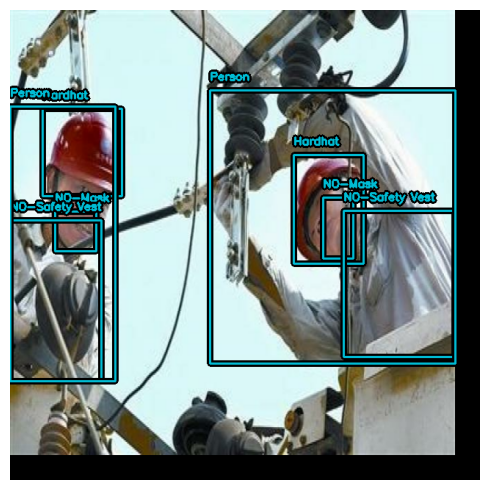

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.5,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

visualize_dataset(
    test_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

## Creating Model

We need to extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [ ]:
def dict_to_tuple(inputs):
  # return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)
  return inputs["images"], inputs["bounding_boxes"]

In [ ]:
train = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train = train.prefetch(tf.data.AUTOTUNE)

val = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)

test = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

## Perform detections with a pretrained model

In [ ]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xyxy"
)

/usr/local/lib/python3.10/dist-packages/keras_cv/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


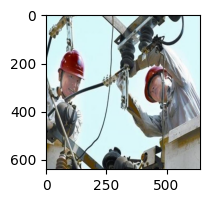

In [ ]:
# get the first image file in content/css-data/test/images
filepath = path_images_test + "/" + os.listdir(path_images_test)[7]
image = keras.utils.load_img(filepath)

# display the image, make it smaller to fit the window
plt.figure(figsize=(2, 2))
plt.imshow(image)

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
)

In [ ]:
image = np.array(image)
image_batch = inference_resizing([image])

1/1 [==============================] - 0s 134ms/step


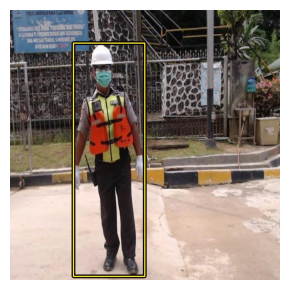

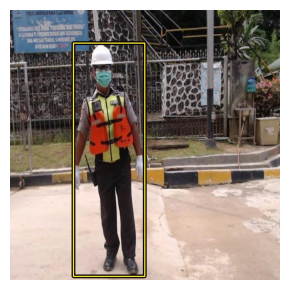

In [ ]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=3,
    font_scale=0.5,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,
)

# Transfer Learnng/Fine-Tuning

[link text](https://)Here is a list of YOLO V8 model that is available in KerasCV depends on the size of the model. YOLOv8x has the highest mAP, parameters, and FLOPs but also the slowest inference speed, while YOLOv8n has the smallest size, fastest inference speed, and lowest mAP, parameters, and FLOPs.


**Without Weights/With Pre-trained coco weight:**

    1.   yolo_v8_xs_backbone/yolo_v8_xs_backbone_coco
    2.   yolo_v8_s_backbone/yolo_v8_s_backbone_coco
    3.   yolo_v8_m_backbone/yolo_v8_m_backbone_coco
    4.   yolo_v8_l_backbone/yolo_v8_l_backbone_coco
    5.   yolo_v8_xl_backbone/yolo_v8_xl_backbone_coco


In [ ]:
backbone_wo_weight = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone"  # use the structure only wo the pre-trained weight
)

100%|██████████| 631/631 [00:00<00:00, 550kB/s]


In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_m_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

/usr/local/lib/python3.10/dist-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
backbone.trainable = False
backbone.trainable

False

Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature
extractor as the `backbone` argument, a `num_classes` argument that specifies the number
of object classes to detect based on the size of the `class_mapping` list, a
`bounding_box_format` argument that informs the model of the format of the bbox in the
dataset, and a finally, the feature pyramid network (FPN) depth is specified by the
`fpn_depth` argument.

In [ ]:
yolo_wo_weight = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone_wo_weight,
    fpn_depth=1,
)

In [ ]:
# for ind_layer in range(len(yolo_wo_weight.layers)):
#     layer = yolo_wo_weight.layers[ind_layer]
#     layer_weight = layer.get_weights()
#     for i in range(len(layer_weight)):
#       print(layer_weight[i])
#       if not layer_weight[i].trainable:
#            print(layer.name, i)

In [ ]:
yolo_wo_weight.layers[10].bias

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
yolo.summary()

Model: "yolov8_detector_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_5 (Functional)        {'P3': (None, None, None,    1277680   ['input_9[0][0]']             
                             64),                                                                 
                              'P4': (None, None, None,                                            
                             128),                                                                
                              'P5': (None, None, None,                                            
                             256)}                                                

## Compile the Model

Loss used for YOLOV8


1. Classification Loss: This loss function calculates the discrepancy between anticipated
class probabilities and actual class probabilities. In this instance,
`binary_crossentropy`, a prominent solution for binary classification issues, is
Utilized. We Utilized binary crossentropy since each thing that is identified is either
classed as belonging to or not belonging to a certain object class (such as a person, a
car, etc.).

2. Box Loss: `box_loss` is the loss function used to measure the difference between the
predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU)
metric is used, which not only measures the overlap between predicted and ground truth
bounding boxes but also considers the difference in aspect ratio, center distance, and
box size. Together, these loss functions help optimize the model for object detection by
minimizing the difference between the predicted and ground truth class probabilities and
bounding boxes.


In [ ]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer1, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo_wo_weight.compile(
    optimizer=optimizer2, classification_loss="binary_crossentropy", box_loss="ciou"
)

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [ ]:

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Train the Model

In [ ]:
yolo_wo_weight.fit(
    train,
    validation_data=val,
    epochs=3,
    callbacks=[callback],
)

In [ ]:
yolo.trainable = False

In [ ]:
history = yolo.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[callback],
)

Epoch 1/10
675/675 [==============================] - 77s 78ms/step - loss: 5.2462 - box_loss: 2.2973 - class_loss: 2.9489 - val_loss: 2.5702 - val_box_loss: 2.2813 - val_class_loss: 0.2889
Epoch 2/10
675/675 [==============================] - 52s 75ms/step - loss: 2.1545 - box_loss: 1.8943 - class_loss: 0.2603 - val_loss: 2.3085 - val_box_loss: 2.0603 - val_class_loss: 0.2482
Epoch 3/10
675/675 [==============================] - 52s 75ms/step - loss: 2.0147 - box_loss: 1.7920 - class_loss: 0.2227 - val_loss: 2.1636 - val_box_loss: 1.9487 - val_class_loss: 0.2150
Epoch 4/10
675/675 [==============================] - 52s 75ms/step - loss: 1.9151 - box_loss: 1.7114 - class_loss: 0.2037 - val_loss: 2.1052 - val_box_loss: 1.8992 - val_class_loss: 0.2060
Epoch 5/10
675/675 [==============================] - 52s 75ms/step - loss: 1.8445 - box_loss: 1.6539 - class_loss: 0.1907 - val_loss: 2.0266 - val_box_loss: 1.8319 - val_class_loss: 0.1947
Epoch 6/10
675/675 [==============================

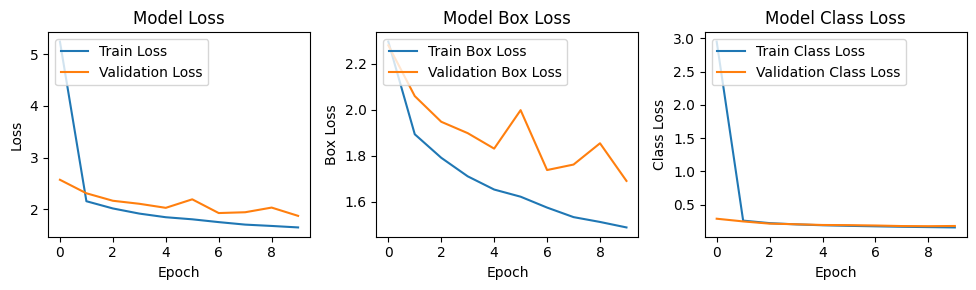

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3)) # 2 rows, 1 column

# Plotting model loss on the first subplot
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

# Plotting model box loss on the second subplot
axs[1].plot(history.history['box_loss'], label='Train Box Loss')
axs[1].plot(history.history['val_box_loss'], label='Validation Box Loss')
axs[1].set_title('Model Box Loss')
axs[1].set_ylabel('Box Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

# Plotting model box loss on the second subplot
axs[2].plot(history.history['class_loss'], label='Train Class Loss')
axs[2].plot(history.history['val_class_loss'], label='Validation Class Loss')
axs[2].set_title('Model Class Loss')
axs[2].set_ylabel('Class Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()

## Visualize Predictions

In [ ]:
# get the first image file in content/css-data/test/images
filepath = path_images_test + "/" + os.listdir(path_images_test)[57]
image = keras.utils.load_img(filepath)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
)

image = np.array(image)
image_batch = inference_resizing([image])

y_pred = yolo.predict(image_batch)

In [ ]:
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,
)

1/1 [==============================] - 0s 204ms/step


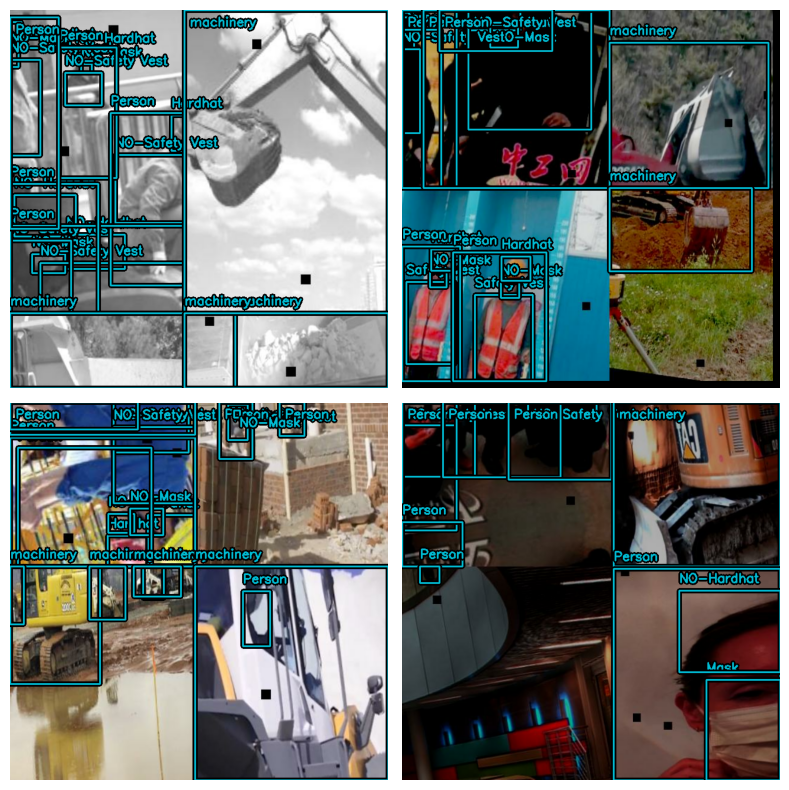

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=test_ds, bounding_box_format="xyxy")

# Fine Tuning

In [ ]:
backbone2 = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_m_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

/usr/local/lib/python3.10/dist-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
backbone2.trainable

True

In [ ]:
yolo2 = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone2,
    fpn_depth=3,
)

In [ ]:
yolo2.summary()

Model: "yolov8_detector_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_7 (Functional)        {'P3': (None, None, None,    1187246   ['input_13[0][0]']            
                             192),                        4                                       
                              'P4': (None, None, None,                                            
                             384),                                                                
                              'P5': (None, None, None,                                            
                             576)}                                                

In [ ]:
optimizer3 = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo2.compile(
    optimizer=optimizer3, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
history2 = yolo2.fit(
    train,
    validation_data=val,
    epochs=1,
    callbacks=[callback],
)

675/675 [==============================] - 107s 95ms/step - loss: 3.5386 - box_loss: 3.1602 - class_loss: 0.3784 - val_loss: 3.8349 - val_box_loss: 3.4353 - val_class_loss: 0.3996


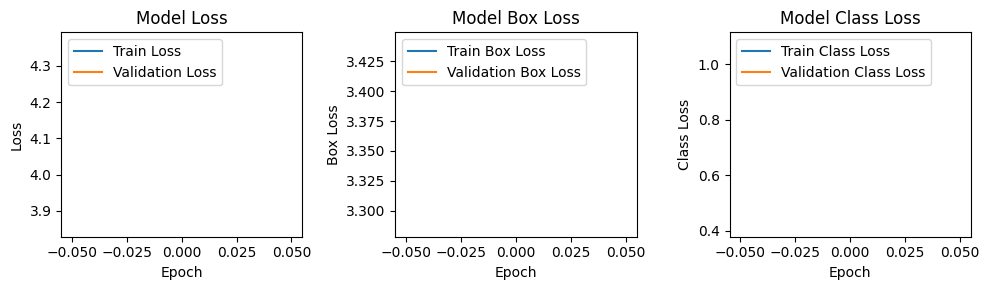

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3)) # 2 rows, 1 column

# Plotting model loss on the first subplot
axs[0].plot(history2.history['loss'], label='Train Loss')
axs[0].plot(history2.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

# Plotting model box loss on the second subplot
axs[1].plot(history2.history['box_loss'], label='Train Box Loss')
axs[1].plot(history2.history['val_box_loss'], label='Validation Box Loss')
axs[1].set_title('Model Box Loss')
axs[1].set_ylabel('Box Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

# Plotting model box loss on the second subplot
axs[2].plot(history2.history['class_loss'], label='Train Class Loss')
axs[2].plot(history2.history['val_class_loss'], label='Validation Class Loss')
axs[2].set_title('Model Class Loss')
axs[2].set_ylabel('Class Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# get the first image file in content/css-data/test/images
filepath = path_images + "/" + os.listdir(path_images)[7]
image = keras.utils.load_img(filepath)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
)

image = np.array(image)
image_batch = inference_resizing([image])

y_pred2 = yolo2.predict(image_batch)

In [ ]:
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred2,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,
)